In [1]:
# import general-use Python libraries
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

# import custom functions from src
from hpc4ag.preprocessing import split_train_test, create_patches
from hpc4ag.modeling import (compile_model, generate_X_and_y,
                             assign_class_weight, apply_scaler_train,
                             apply_scaler_test)
from hpc4ag.visualization import (map_training_labels, plot_sample_distribution,
                                  map_timeseries_oneband, plot_indices_temporal,
                                  plot_confusion_matrix)
from hpc4ag.utils import download_file, get_tmpdest, load_pickle, save_pickle

2024-08-08 09:26:18.277700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Configurations**
We use the following data formats to store our data:
- `.shp` is one of the most common formats to store `spatial vector data` (geographic features that can be represented by points, lines, or polygons). For more information https://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm;
- `.sr6d` is a custom data format used here to serialize a Python object structure and store data as Python `pickles`. In our case we are storing Python dictionaries, which are structured as `{key : value}` pairs. For more information on pickles https://docs.python.org/3/library/pickle.html and dictionaries https://docs.python.org/3/tutorial/datastructures.html#dictionaries.

Data Repository: all data files are stored in s3 bucket configured for public "read" access (`https://s3.msi.umn.edu/hpc4ag/csb`). We will download the data on the fly and generate local temporary files and directories to store and access data during the process.

In [2]:
shapefile_data_filename = "chippewa-mn-csb-2022-training-set-wsg84.zip"

raw_data_filename = "chippewa_v2m58_plf_y2022_s{}.sr6d"

train_filename = "train_patches.sr6d"
test_filename = "test_patches.sr6d"

crop_list = ["Corn", "Soybeans", "Sugarbeets"]

### **Step 0. Formulate your research objective and understand your data**

**Research Objective:** Predict crop types (Corn, Soybeans, Sugarbeets, Spring Wheat) in one county in Minnesota using time series Sentinel data and a neural network model.  
**Problem Type:** Classification  
**Study Period:** 2022  
**Data:**
- observations - Sentinel data
- labels - crop types

Ideally, crop type labels should be ground truth data. However, this type of data is often confidential, and therefore for this tutorial we use a modeled data sample - USDA's `Crop Sequence Boundaries (CSB)` to "imitate" real crop type labels in 2022. For more information on this dataset follow https://www.nass.usda.gov/Research_and_Science/Crop-Sequence-Boundaries/index.php.

Note that we have only 280 agricultural field labels, but each field is comprised of many individual observations (pixels). Sentinel data files have a multi-dimensional dictionary structure to store spectral information needed for the spatiotemporal analysis in an organized way. The `grid` component of one data file is a 4D array with shape (time, band, row, column). Sentinel data have been sampled/interpolated at a 5-day interval.

In [3]:
training_labels_gdf = gpd.read_file(download_file(bucket_path="csb/", filename=shapefile_data_filename))
# filter original gdf to exlcude Spring Wheat
training_labels_gdf = training_labels_gdf[training_labels_gdf["CSB 2022"] != "Spring Wheat"]
# get field ids of all fields after filtering 
field_ids = training_labels_gdf.index.to_list()
print ("Count of agricultural fields:", len(training_labels_gdf))
training_labels_gdf.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/iaa/oboiko/.conda/envs/hpclearn/share/proj failed


Count of agricultural fields: 279


,CSBID,CSBACRES,CNTY,R22,CSB 2022,geometry
0,271522004078341,108.770301,Chippewa,1,Corn,"POLYGON ((-95.67592 45.09052, -95.67587 45.089..."
1,271522004072675,125.919779,Chippewa,5,Soybeans,"POLYGON ((-95.33463 44.93432, -95.33451 44.934..."
2,271522001276040,250.504136,Chippewa,1,Corn,"POLYGON ((-95.88877 45.12273, -95.88877 45.121..."
3,271522004078590,222.898043,Chippewa,1,Corn,"POLYGON ((-95.48071 45.06445, -95.48067 45.064..."
4,271522001275800,145.191459,Chippewa,1,Corn,"POLYGON ((-95.61433 45.12228, -95.61433 45.115..."


Above we have printed the head of our `GeoDataFrame` to explore the data attributes (`GeoDataFrame` is a Python's data structure provided by the `geopandas` library to handle spatial vector data).
- `CSBID` - unique field ID;
- `CSBACRES` - field area in acres;
- `CNTY` - county name;
- `R22` - crop type in 2022, stored as a numeric value;
- `CSB 2022` - crop type in 2022, stored as a text value;
- `geometry` column enables spatial operations.

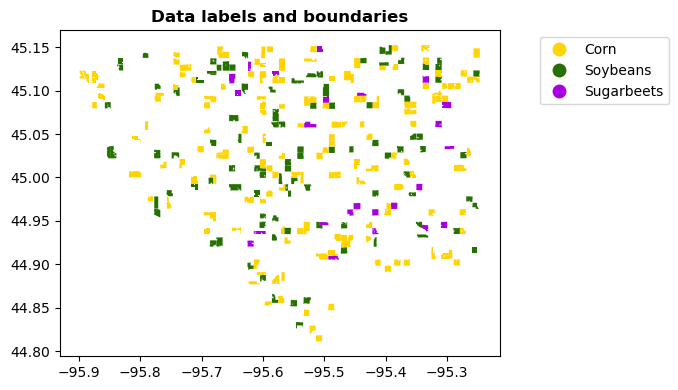

In [4]:
map_training_labels(gdf=training_labels_gdf, column_name="CSB 2022")

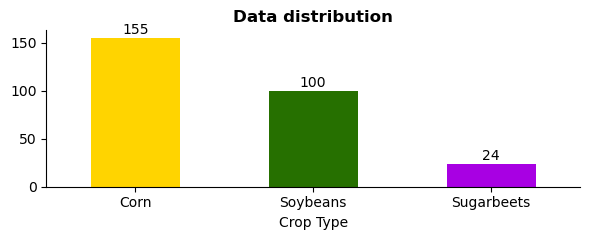

In [5]:
plot_sample_distribution(gdf=training_labels_gdf, column_name="CSB 2022")

In [6]:
# get a random item from field ids list
random_filepath = download_file(bucket_path="csb/", filename=raw_data_filename.format(random.choice(field_ids)))
print("Random field :",  random_filepath)

Random field : /tmp/tmpu4zcyevh/chippewa_v2m58_plf_y2022_s186.sr6d


- Below we load the data from a Python pickle (described at the beginning) into a Python dictionary and show how to unpack the dictionary structure to read important information about the data, such as the dates of observations.

In [7]:
# load random data file and check metadata
field_data = load_pickle(filepath=random_filepath)
print ("Overview of data components:", list(field_data.keys()))
print ("Bands:", field_data["grid_info"])
grid = field_data["samples"][0]["grids"][0]
stack = grid["stack"]
dates = grid["dates"]
print ("Dates:", dates)

Overview of data components: ['shapes', 'grid_list', 'grid_info', 'require', 'scalings', 's_arrays', 'samples']
Bands: [{'grid': 'R20m', 'bands': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'Days2data']}]
Dates: ['2022-03-14', '2022-03-19', '2022-03-24', '2022-03-29', '2022-04-03', '2022-04-08', '2022-04-13', '2022-04-18', '2022-04-23', '2022-04-28', '2022-05-03', '2022-05-08', '2022-05-13', '2022-05-18', '2022-05-23', '2022-05-28', '2022-06-02', '2022-06-07', '2022-06-12', '2022-06-17', '2022-06-22', '2022-06-27', '2022-07-02', '2022-07-07', '2022-07-12', '2022-07-17', '2022-07-22', '2022-07-27', '2022-08-01', '2022-08-06', '2022-08-11', '2022-08-16', '2022-08-21', '2022-08-26', '2022-08-31', '2022-09-05', '2022-09-10', '2022-09-15', '2022-09-20', '2022-09-25', '2022-09-30', '2022-10-05', '2022-10-10', '2022-10-15', '2022-10-20', '2022-10-25', '2022-10-30', '2022-11-04']


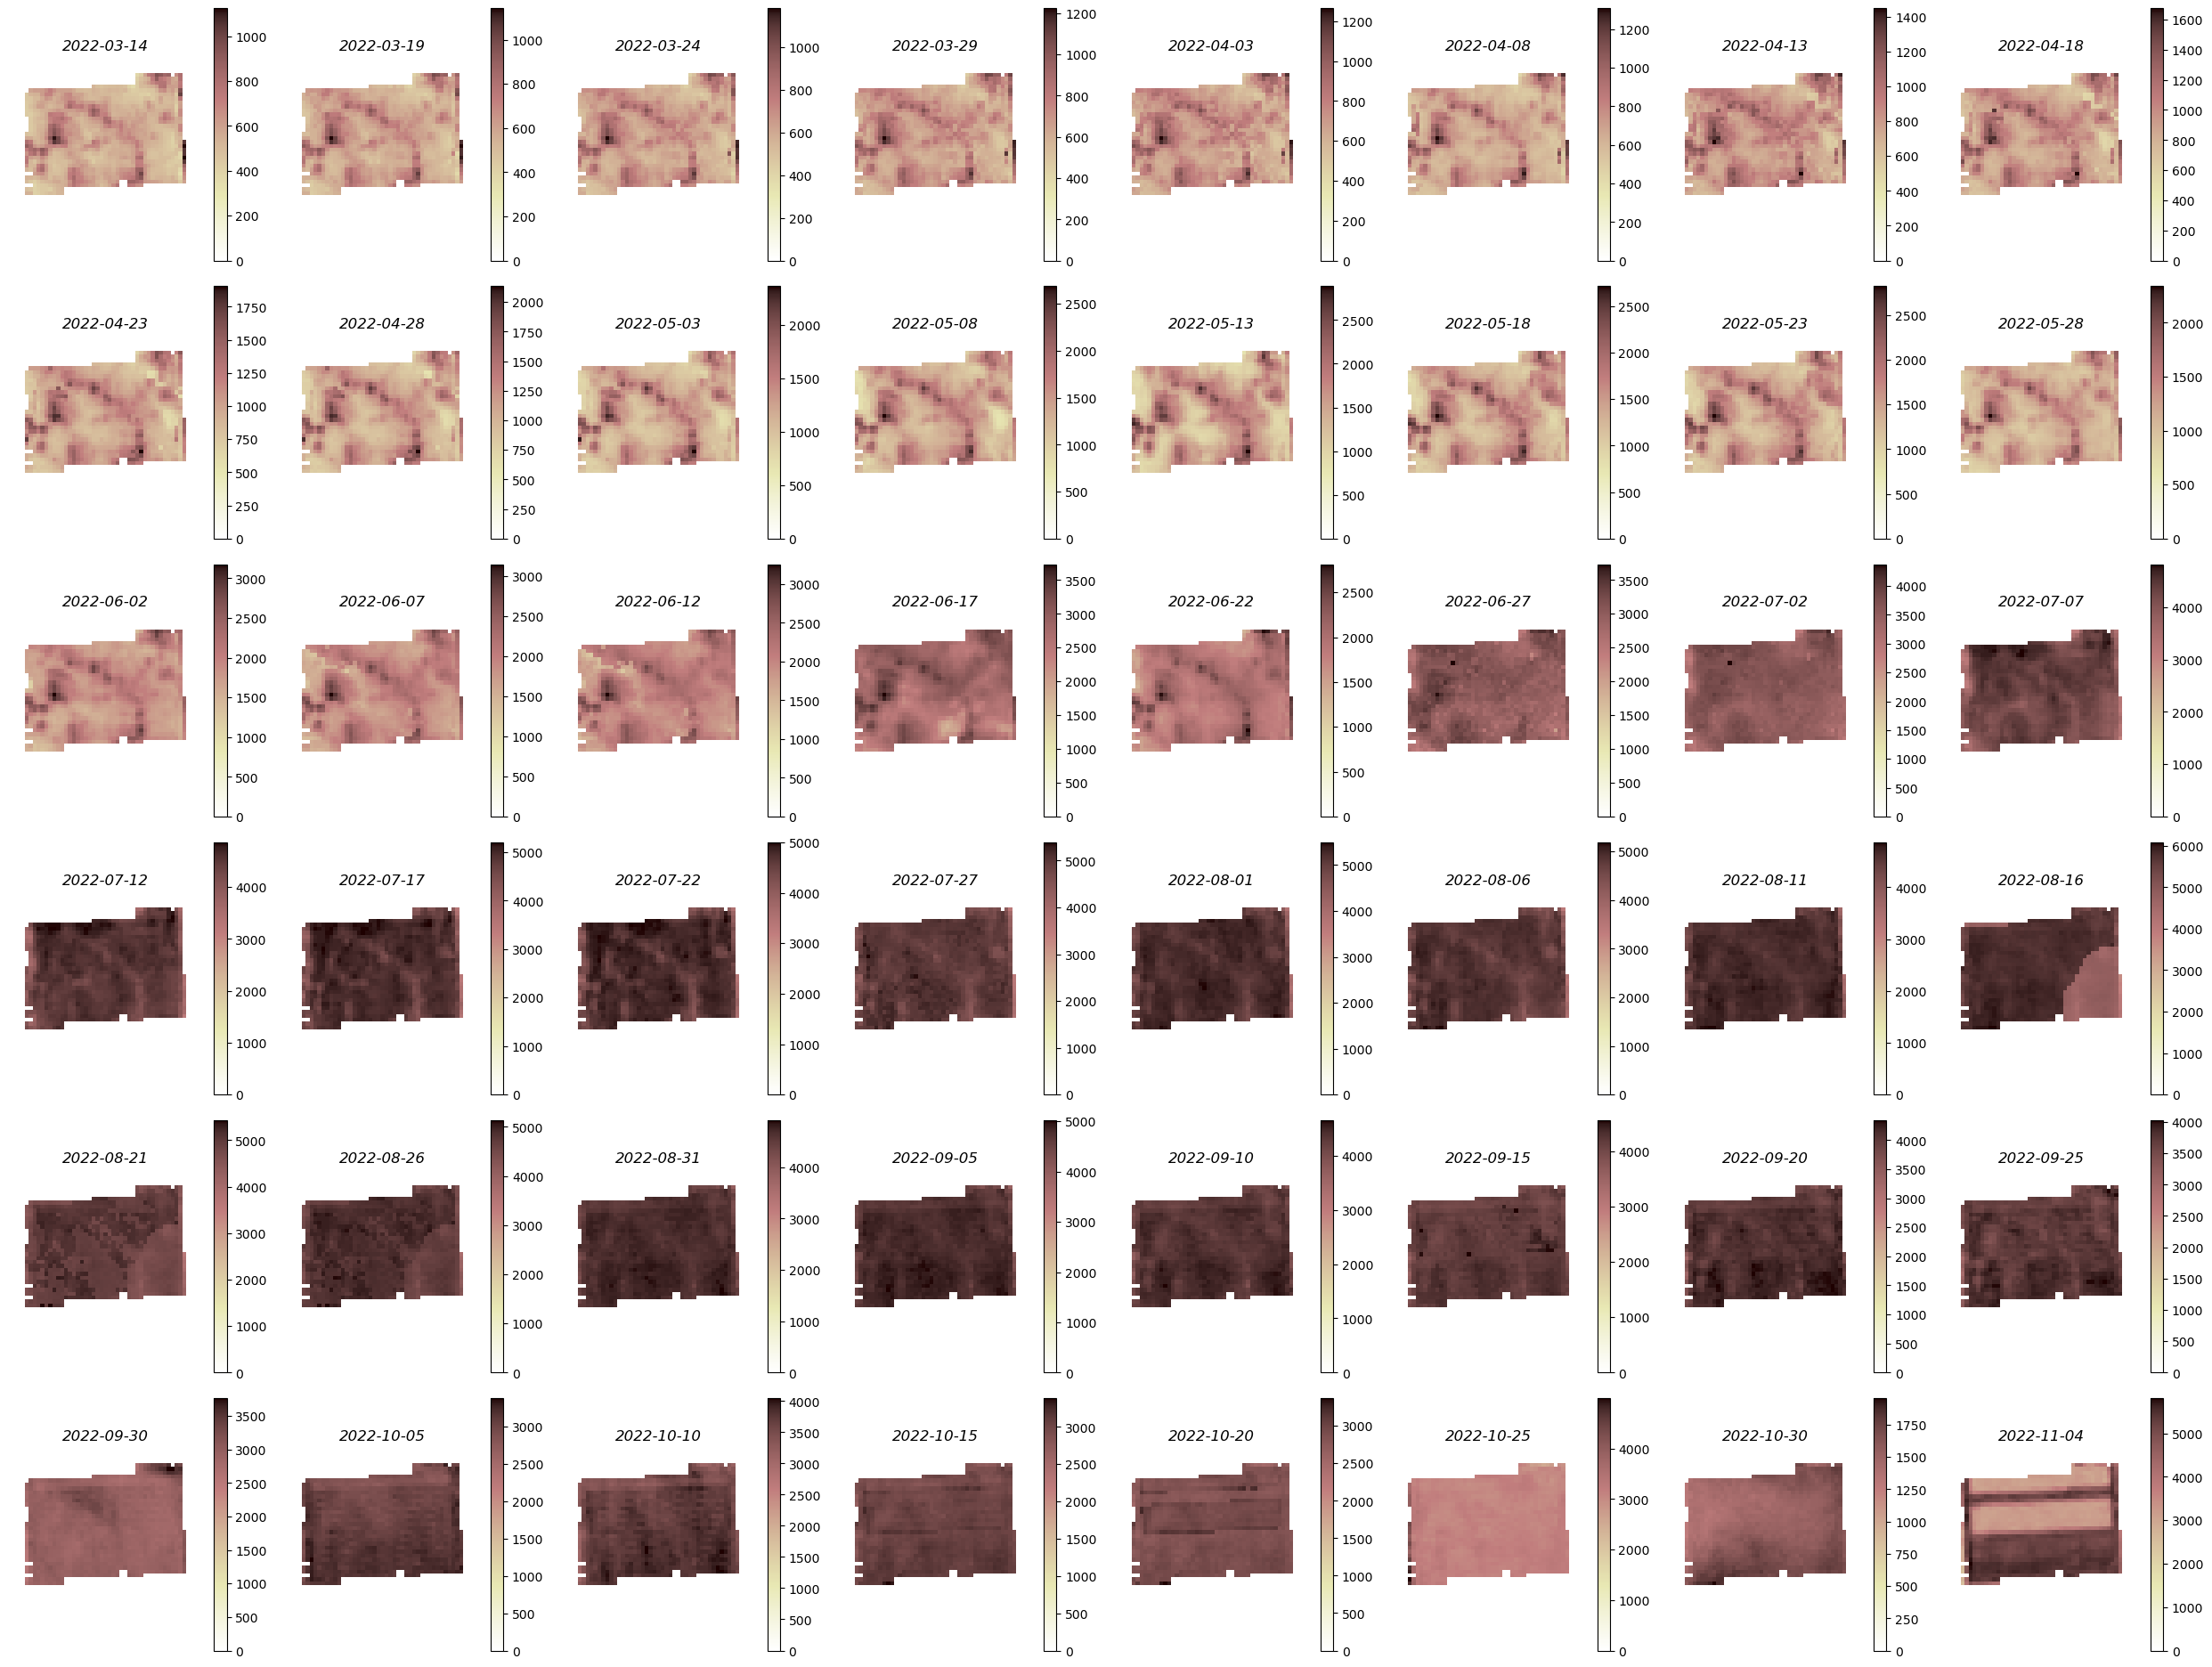

In [8]:
# visualize grid sample
map_timeseries_oneband(array=stack, band_index=8, dates=dates)

### **Step 1. Split input data into train and test sets**

We split the data at a **field** level (NOT **pixel** level) to ensure that pixels from the same field do not appear in both train and test sets. We use the default  80% (train) to 20% (test) ratio.

In [9]:
train_ids, test_ids = split_train_test(objects=field_ids, test_size=0.2)

# Print the count of train and test IDs
print("Count of train fields:", len(train_ids))
print("Count test fields:", len(test_ids))

Count of train fields: 223
Count test fields: 56


### **Step 2. Data augmentation: compute vegetation indices and create image patches**

Data preprocessing, cleaning, and augmentation is often the most time-consuming part of a research workflow. This is a multi-step process that will depend on your research objectives and study design. We propose to compute vegetation indices from raw Sentinel bands and use them as input thematic layers. We selected:

- `Normalized Difference Vegetation Index (NDVI)` https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/;
- `Red-edge Chlorophyll Index (CIre))` https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/chl_rededge/. 

In order to maximize the window of time where all fields have complete, cloud-free data, we have also trimmed our time series to the period from 2022-05-11 to 2022-10-09 (resulting in 31 field-level observations for each field sampled at a 5-day interval). Finally we have split our input field images into 3 by 3 patches. As a result, a single unit (patch) from this step is a 4D array with (31,2,3,3) shape. We save the output from this step for future use.

Below for demonstration we select 4 random fields (one of each crop) and plot the time series of their NDVI and CIre values aggregated to a field median to illustrate the differences between the growing seasons of different crops.

In [10]:
# you can re-run this cell multiple times to plot a different random selection of fields
selected_fields = {
    crop: random.choice(
        list(training_labels_gdf[training_labels_gdf["CSB 2022"]==crop].index)) for crop in crop_list}
print ("Our random choices are : ", selected_fields)

Our random choices are :  {'Corn': 134, 'Soybeans': 218, 'Sugarbeets': 276}


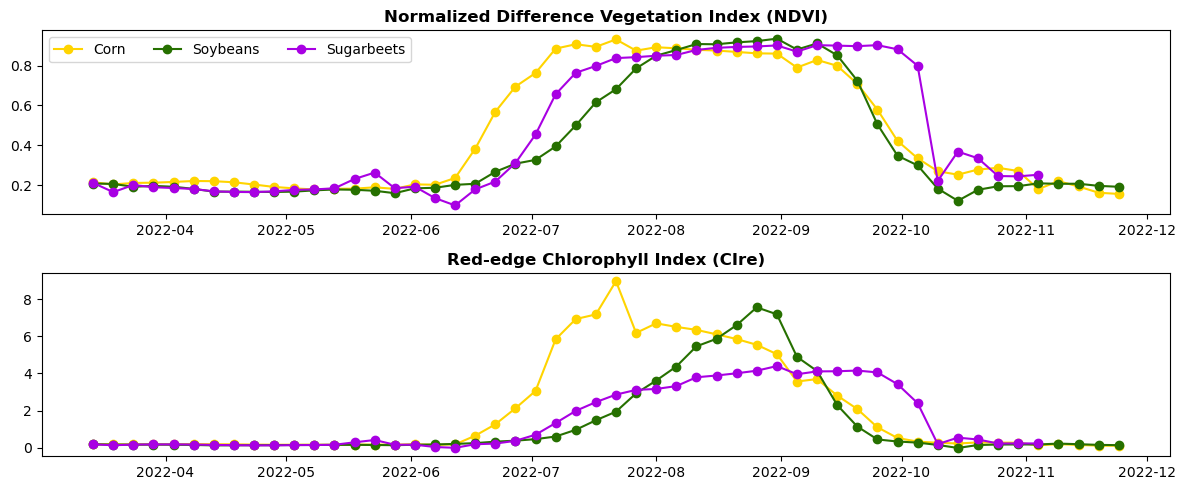

In [11]:
plot_indices_temporal(selected_fields = selected_fields,
                      filepath = raw_data_filename)

#### **Create training patches**

In [12]:
%%time
create_patches(
    fids=train_ids,
    filepath=raw_data_filename,
    outfilepath=get_tmpdest(train_filename),
    patch_height=3, patch_width=3,
    allow_overlap=False,
    start_end_dates=["2022-05-11", "2022-10-11"]
)

CPU times: user 6.88 s, sys: 8.72 s, total: 15.6 s
Wall time: 27.2 s


#### **Create test patches**

In [13]:
%%time
create_patches(
    fids=test_ids,
    filepath=raw_data_filename,
    outfilepath=get_tmpdest(test_filename),
    patch_height=3, patch_width=3,
    allow_overlap=False,
    start_end_dates=["2022-05-11", "2022-10-11"]
)

CPU times: user 1.81 s, sys: 2.01 s, total: 3.82 s
Wall time: 6.91 s


### **Step 3. Format/normalize input labels and observations**

#### **Format labels**
One hot encoding is needed to represent categorical variables in a machine learning model. After applying this technique to our labels, we load the train data and assign a one hot encoded label value to each patch. For more examples https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/. See an illustration below:

From the following input:

|category|
|--------|
| dog    |
| cat    |
| fox    |

We can generate the following one hot encoded representation:

| dog    | cat    | fox    |
|--------|--------|--------|
|**True**| False  | False  |
| False  |**True**| False  |
| False  | False  |**True**|

In [14]:
one_hot_encoded_labels = pd.get_dummies(training_labels_gdf[["CSB 2022"]],
                                        columns = ["CSB 2022"], prefix_sep=" ") 
one_hot_encoded_labels.head()

,CSB 2022 Corn,CSB 2022 Soybeans,CSB 2022 Sugarbeets
0,True,False,False
1,False,True,False
2,True,False,False
3,True,False,False
4,True,False,False


#### **Assign data labels to data observations**

During this step, we are loading our train patches and labels to create our training dataset (`X_train`) and corresponding labels (`y_train`). This involves organizing the patches and their corresponding labels by pairing each patch with its corresponding label.

In [15]:
train  = load_pickle(filepath=get_tmpdest(train_filename))
print(train.keys())

dict_keys([262, 125, 33, 87, 266, 222, 37, 141, 16, 194, 245, 67, 133, 155, 116, 138, 264, 77, 18, 193, 217, 94, 120, 93, 174, 55, 261, 211, 38, 171, 144, 57, 269, 219, 179, 31, 265, 78, 205, 121, 240, 112, 186, 109, 180, 110, 278, 69, 114, 2, 105, 76, 113, 147, 159, 97, 118, 148, 182, 225, 74, 128, 29, 226, 203, 246, 149, 268, 5, 117, 56, 158, 184, 65, 166, 85, 181, 12, 35, 28, 212, 140, 51, 96, 176, 275, 41, 241, 185, 137, 26, 273, 142, 168, 0, 242, 101, 218, 213, 99, 36, 61, 151, 198, 257, 202, 11, 276, 239, 27, 187, 4, 123, 32, 221, 163, 177, 216, 139, 62, 136, 129, 270, 230, 70, 233, 64, 44, 197, 157, 40, 124, 223, 154, 23, 228, 224, 81, 39, 201, 252, 47, 95, 231, 248, 162, 43, 146, 191, 209, 3, 106, 53, 134, 1, 234, 104, 49, 164, 80, 206, 34, 249, 7, 172, 199, 254, 111, 92, 83, 130, 52, 90, 8, 13, 59, 89, 132, 17, 167, 72, 274, 135, 247, 229, 267, 63, 244, 54, 108, 50, 250, 175, 251, 190, 14, 208, 188, 220, 256, 170, 58, 48, 236, 253, 21, 161, 192, 258, 150, 131, 152, 100, 88, 21

In [16]:
X_train, y_train = generate_X_and_y(data=train, one_hot_encoded_labels=one_hot_encoded_labels)
print ("X shape: ", X_train.shape)
print ("y shape: ", y_train.shape)

X shape:  (30826, 31, 2, 3, 3)
y shape:  (30826, 3)


#### **Normalize the input data using the `sklearn` MinMaxScaler**
We apply a scaler to each feature separately to normalize the data into the range `[0,1]`, so the minimum value of each feature becomes 0 and the maximum value becomes 1. This helps to ensure that no single feature dominates. Note: we fit the scaler to only `X_train` to be sure the model does not get information from the test set.

In [17]:
X_train_scaled, scalers = apply_scaler_train(X_train=X_train)

In [18]:
# check original and scaled min and max of your data to see if it worked
print (X_train.min(), X_train.max())
print (X_train_scaled.min(), X_train_scaled.max())

-0.991539 14.998193
0.0 1.0


### **Step 4. Configure and train a model**

#### **Compile a model**
We compile Simple Recurrent Neural Network (RNN) model to process sequential (in our case time series) data input. For more information on model parameters follow `keras` documentation: https://keras.io/api/layers/recurrent_layers/simple_rnn/.

In [19]:
model = compile_model(shape=(31, 2, 3, 3), kind="SimpleRNN", n_classes=3)
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 31, 18)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 3)                 66        
                                                                 
Total params: 66 (264.00 Byte)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### **Compute class weights**
We can adjust the weight for the model to give more attention to the minority classes. This allows us to balance out under-represented (Sugarbeets) and over-represented (Soybeans) classes in the training set.

In [20]:
# count the True values for each class type
y_train_counts = np.sum(y_train, axis=0)
print("Number of values for each class:", y_train_counts)

Number of values for each class: [17774 10033  3019]


In [21]:
class_weight = assign_class_weight(y=y_train)
print (class_weight)

{0: 0.5781103484490454, 1: 1.0241536263663245, 2: 3.4035552611239925}


#### **Fit the model**

During this process, we train the model using the train data and the parameters given. Our goal is to "teach" the model to generalize patterns in the data in order to predict a most likely outcome (crop type).

In [22]:
%%time
history = model.fit(X_train_scaled, y_train,
                    batch_size=32, epochs=30, validation_split=0.2,
                    class_weight=class_weight)

Epoch 1/30
771/771 [==============================] - 3s 4ms/step - loss: 1.0609 - accuracy: 0.2954 - val_loss: 0.9376 - val_accuracy: 0.6837
Epoch 2/30
771/771 [==============================] - 2s 3ms/step - loss: 0.7912 - accuracy: 0.6856 - val_loss: 0.7833 - val_accuracy: 0.7650
Epoch 3/30
771/771 [==============================] - 2s 3ms/step - loss: 0.6085 - accuracy: 0.8086 - val_loss: 0.6793 - val_accuracy: 0.8013
Epoch 4/30
771/771 [==============================] - 2s 3ms/step - loss: 0.5219 - accuracy: 0.8240 - val_loss: 0.6166 - val_accuracy: 0.7841
Epoch 5/30
771/771 [==============================] - 2s 3ms/step - loss: 0.4768 - accuracy: 0.8321 - val_loss: 0.5997 - val_accuracy: 0.8062
Epoch 6/30
771/771 [==============================] - 2s 3ms/step - loss: 0.4504 - accuracy: 0.8373 - val_loss: 0.5680 - val_accuracy: 0.8107
Epoch 7/30
771/771 [==============================] - 2s 3ms/step - loss: 0.4321 - accuracy: 0.8399 - val_loss: 0.5657 - val_accuracy: 0.8177
Epoch 

### **Step 5. Make predictions and evaluate accuracy**
`X_test` and `y_test` need to go through the same preparatory steps as `X_train` and `y_train`.
- We load the test data from the `pickle` into a dictionary:

In [23]:
test  = load_pickle(filepath=get_tmpdest(test_filename))
print(test.keys())

dict_keys([30, 127, 200, 143, 255, 238, 98, 207, 259, 145, 79, 210, 232, 102, 196, 115, 195, 60, 204, 243, 45, 73, 183, 260, 277, 214, 84, 42, 9, 119, 22, 156, 24, 169, 227, 75, 235, 237, 6, 68, 46, 178, 66, 25, 126, 165, 19, 82, 173, 272, 91, 153, 263, 15, 160, 10])


- We pair each test patch with the corresponding crop type label:

In [24]:
X_test, y_test = generate_X_and_y(data=test, one_hot_encoded_labels=one_hot_encoded_labels)
print ("X shape: ", X_test.shape)
print ("y shape: ", y_test.shape)

X shape:  (7880, 31, 2, 3, 3)
y shape:  (7880, 3)


- We apply scalers (previously generated using the train data) to adjust the range of values:

In [25]:
X_test_scaled = apply_scaler_test(X_test=X_test, scalers=scalers)

In [26]:
# check original and scaled min and max of your data to see if it worked
print (X_test.min(), X_test.max())
print (X_test_scaled.min(), X_test_scaled.max())

-0.573491 14.952701
0.02614478 1.000018


- We generate predictions. Note that the model does NOT output an exact label (crop type) but rather an array representing the model's estimated probabilities that the input belongs to each of the suggested classes. Therefore, `np.argmax` is applied to return the index corresponding to the highest probability.

In [27]:
y_pred = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred, axis=1)

247/247 [==============================] - 0s 1ms/step


- Here we format the true labels (`y_test`) for direct comparison with the model output:

In [28]:
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(np.argmax(y_test, axis=1))

- Finally, we use a **confusion matrix** as a performance measurement for our machine learning model. It is a great visual and quantitative way to show how many predictions are correct and incorrect for each class. It reveals which classes are more distinct and which ones are often confused by model as other classes, indicating lower separability.

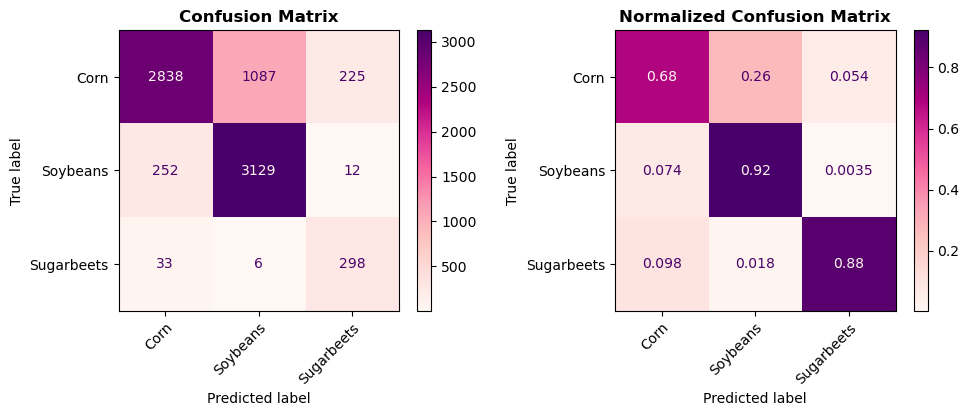

In [29]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred,
                      display_labels=["Corn", "Soybeans", "Sugarbeets"])

- Below we also compute F1 score to evaluate overall model performance. It considers both precision and recall. The values of the F1 score range from 0 to 1 (higher values indicate better performace).

In [30]:
F1 = f1_score(y_true, y_pred, average="weighted")
print ("F1 score is:", F1)

F1 score is: 0.7940920292427477


### **Step 6. Apply and test the model outside of the training area**

In this section we test if the model can be generalized to other counties in Minnesota.

- **Review new data.** We check the distribution of the new labels collected in a different county with a different crop profile.

In [31]:
shapefile_data_filename_new = "norman-mn-csb-2022-training-set-wsg84.zip"

raw_data_filename_new = "csb_v2m58_plf_y2022_s{}.sr6d"

#field_ids = list(range(0,280))

test_filename_new = "test_patches_new.sr6d"

In [32]:
training_labels_gdf_new = gpd.read_file(download_file(bucket_path="csb/", filename=shapefile_data_filename_new))
# filter original gdf to exlcude Spring Wheat
training_labels_gdf_new = training_labels_gdf_new[training_labels_gdf_new["CSB 2022"] != "Spring Wheat"]
# get field ids of all fields after filtering 
field_ids = training_labels_gdf_new.index.to_list()
print ("Count of agricultural fields:", len(training_labels_gdf_new))
training_labels_gdf_new.head()

Count of agricultural fields: 212


,CSBID,CSBACRES,CNTY,R22,CSB 2022,geometry
0,271522001344627,151.907626,Norman,1,Corn,"POLYGON ((-96.54337 47.35405, -96.54337 47.353..."
1,271522001249576,146.614302,Norman,5,Soybeans,"POLYGON ((-96.65440 47.28147, -96.65440 47.281..."
2,271522001310895,337.024319,Norman,1,Corn,"POLYGON ((-96.24845 47.45655, -96.24845 47.456..."
3,271522001254935,148.622804,Norman,5,Soybeans,"POLYGON ((-96.41779 47.22326, -96.41779 47.222..."
4,271522001367192,116.632150,Norman,5,Soybeans,"POLYGON ((-96.82571 47.36780, -96.82571 47.367..."


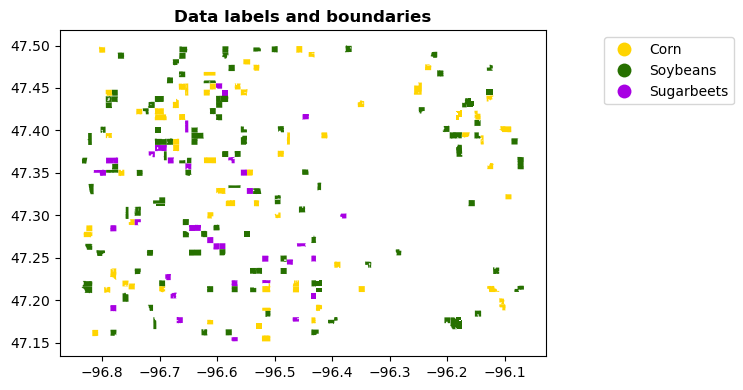

In [33]:
map_training_labels(gdf=training_labels_gdf_new, column_name="CSB 2022")

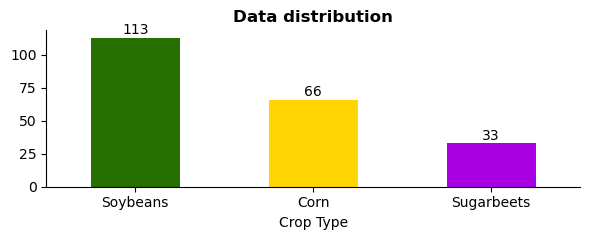

In [34]:
plot_sample_distribution(gdf=training_labels_gdf_new, column_name="CSB 2022")

- **Create new test patches**

In [35]:
%%time
create_patches(
    fids=field_ids,
    filepath=raw_data_filename_new,
    outfilepath=get_tmpdest(test_filename_new),
    patch_height=3, patch_width=3,
    allow_overlap=False,
    start_end_dates=["2022-05-11", "2022-10-11"]
)

CPU times: user 5.96 s, sys: 6.87 s, total: 12.8 s
Wall time: 24.1 s


- **Format labels**

In [36]:
one_hot_encoded_labels_new = pd.get_dummies(training_labels_gdf_new[["CSB 2022"]],
                                            columns = ["CSB 2022"], prefix_sep=" ") 
one_hot_encoded_labels_new.head()

,CSB 2022 Corn,CSB 2022 Soybeans,CSB 2022 Sugarbeets
0,True,False,False
1,False,True,False
2,True,False,False
3,False,True,False
4,False,True,False


- **Assign data labels to data observations**

In [37]:
test_new  = load_pickle(filepath=get_tmpdest(test_filename_new))
print(test_new.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 70, 71, 72, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 113, 115, 117, 118, 120, 121, 122, 125, 126, 127, 128, 129, 130, 131, 132, 133, 139, 141, 142, 143, 144, 145, 146, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 176, 177, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 193, 194, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 228, 230, 232, 233, 234, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 268, 269, 270, 273, 274, 275, 276, 277, 278])


In [38]:
X_test_new, y_test_new = generate_X_and_y(data=test_new, one_hot_encoded_labels=one_hot_encoded_labels_new)
print ("X shape: ", X_test_new.shape)
print ("y shape: ", y_test_new.shape)

X shape:  (31541, 31, 2, 3, 3)
y shape:  (31541, 3)


- **Normalize the input data using scalers**

In [39]:
X_test_scaled_new = apply_scaler_test(X_test=X_test_new, scalers=scalers)

In [40]:
# check original and scaled min and max of your data to see if it worked
print (X_test_new.min(), X_test_new.max())
print (X_test_scaled_new.min(), X_test_scaled_new.max())

-1.0 14.93327
-0.011170447 1.0001464


- **Generate predictions**

In [41]:
y_pred_new = model.predict(X_test_scaled_new)
y_pred_new = np.argmax(y_pred_new, axis=1)

986/986 [==============================] - 1s 1ms/step


- **Accuracy assessment**

In [42]:
label_encoder = LabelEncoder()
y_true_new = label_encoder.fit_transform(np.argmax(y_test_new, axis=1))

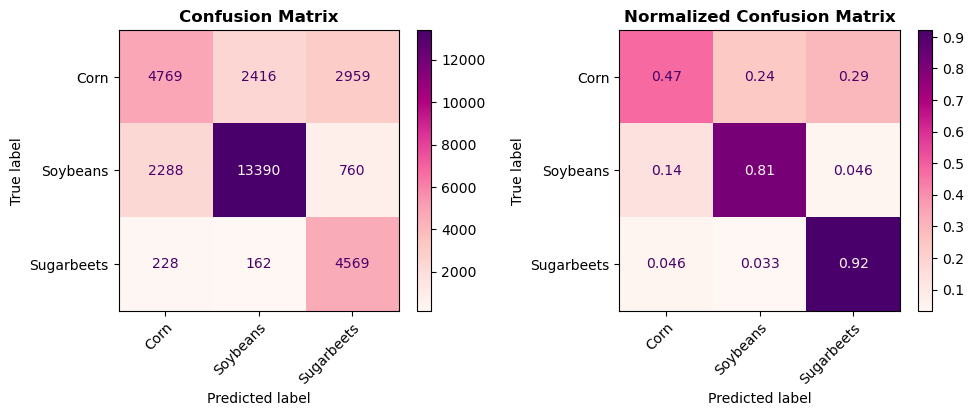

In [43]:
plot_confusion_matrix(y_true=y_true_new, y_pred=y_pred_new,
                      display_labels=["Corn", "Soybeans", "Sugarbeets"])

In [44]:
F1 = f1_score(y_true_new, y_pred_new, average="weighted")
print ("F1 score is:", F1)

F1 score is: 0.7151420131676682
